In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import string
import glob
from tqdm import tqdm
import cv2
import pickle
from concurrent.futures import ProcessPoolExecutor

# Exploration

## Observations:
* The plate is 16 columns and 24 rows
* Every well in train_df has all 6 images

In [2]:
# DATA_DIR = '/data/'
DATA_DIR = os.path.join(os.getcwd(), 'data')
RECURSION_DIR = os.path.join(DATA_DIR, 'recursion')
RECURSION_TRAIN = os.path.join(RECURSION_DIR, 'train')
RECURSION_TEST = os.path.join(RECURSION_DIR, 'test')
CELL_TYPES = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
PLATES = ['Plate1', 'Plate2', 'Plate3', 'Plate4']
LETTER_TO_IX = {}
for ix, letter in enumerate(string.ascii_uppercase[1:15]):
    LETTER_TO_IX[letter] = ix 
IX_TO_LETTER = {v: k for k, v in LETTER_TO_IX.items()}

def parse_filename(s, full_path=False):
    ''' Returns row, col, site, channel of a string in the format of the kaggle filename. '''
    #first _ is always 3rd index
    if full_path:
        s = s[-13:]
    col = LETTER_TO_IX[s[0]]
    row = int(s[1:3]) - 2
    site = int(s[5:6]) - 1
    channel = int(s[8:9]) - 1
    return row, col, site, channel  

def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
    return img

def read_parse_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
    info = parse_filename(path, True)
    return img, info

In [4]:
class Plate:
    def __init__(self, cell_type, plate_num):
        self.images = np.zeros((22, 14, 2, 6, 512, 512), dtype=np.float32) - 1
        self.labels = np.zeros((22, 14), dtype=np.int32) - 1 
        self.cell_type = cell_type
        self.plate_num = plate_num
        
    def load_images(self, files):
        with ProcessPoolExecutor(max_workers=4) as executor:
            images, indices = zip(*executor.map(read_parse_image, files))
        images = np.array(images)
        indices = np.array(indices)
        self.images[indices[:, 0], indices[:, 1], indices[:, 2], indices[:, 3]] = images
        
    def get_image(self, s):
        ix = parse_filename(s)
        return self.images[ix]
    
    def __repr__(self):
        return f'<Plate: plate_num: {self.plate_num}, cell_type: {self.cell_type}>'

class Experiment: 
    def __init__(self, cell_type, exp_num, split):
        self.cell_type = cell_type
        self.exp_num = exp_num
        self.split = split 
        self.plates = []
        
    def load_plates(self):
        exp_dir = os.path.join(RECURSION_DIR, self.split, '{}-{:02d}'.format(self.cell_type, self.exp_num))
        for i, p in enumerate(PLATES):
            plate = Plate(self.cell_type, i+1)
            plate_dir = os.path.join(exp_dir, p)
            plate_files = os.listdir(plate_dir)
            plate_files = glob.glob(f'{plate_dir}/*.png')
            plate.load_images(plate_files)
            self.plates.append(plate)
        
    def __repr__(self):
        return f'<Experiment: cell_type: {self.cell_type}, exp_num: {self.exp_num}, split: {self.split} >'

In [5]:
%%time
exp1 = Experiment('HEPG2', 1, 'train')
exp1.load_plates()

CPU times: user 20.6 s, sys: 1min 20s, total: 1min 40s
Wall time: 38.3 s


In [7]:
%%time
exp2 = Experiment('HEPG2', 2, 'train')
exp2.load_plates()

CPU times: user 20.1 s, sys: 1min 21s, total: 1min 41s
Wall time: 40 s


Different ways of visualizing the data:

We can also take the mean, max, and min of the 6 channels

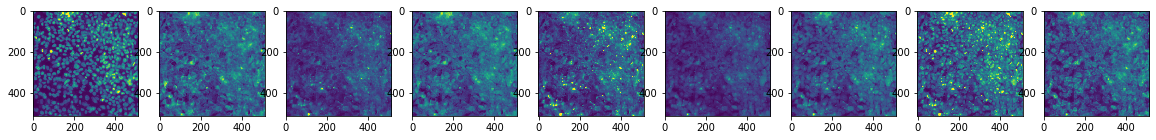

In [208]:
well = (10, 10)
site = 1
plate = 0
fig, axes = plt.subplots(1, 9, figsize=(20, 20))
for c in range(6):
    axes[c].imshow(exp1.plates[plate].images[well[0], well[1], site, c])
axes[6].imshow(exp1.plates[plate].images[well[0], well[1], site].mean(0))
axes[7].imshow(exp1.plates[plate].images[well[0], well[1], site].max(0))
axes[8].imshow(exp1.plates[plate].images[well[0], well[1], site].min(0))

In [8]:
train_df = pd.read_csv(os.path.join(RECURSION_TRAIN, 'train.csv'))
train_controls_df = pd.read_csv(os.path.join(RECURSION_TRAIN, 'train_controls.csv'))

## Exporting some lookup tables
These will come in handy when constructing the dataset

In [158]:
id_to_path_sirna_else = {}
sirna_to_id = {}
for i in tqdm(range(len(train_df))):
    id_, experiment, plate, well, sirna = train_df.iloc[i]
    path = os.path.join(RECURSION_TRAIN, experiment, f'Plate{plate}', well)
    paths = []
    for s in range(2):
        paths.append([])
        for c in range(6):
            paths[s].append(f'{path}_s{s+1}_w{c+1}.png')
    id_to_path_sirna[id_] = ([site1_paths,  site2_paths], sirna)
    if sirna not in sirna_to_id:
        sirna_to_id[sirna] = set()
    sirna_to_id[sirna].add(id_)
    
for i in tqdm(range(len(train_controls_df))):
    id_, experiment, plate, well, sirna, _ = train_controls_df.iloc[i]
    path = os.path.join(RECURSION_TRAIN, experiment, f'Plate{plate}', well)
    paths = []
    for s in range(2):
        paths.append([])
        for c in range(6):
            paths[s].append(f'{path}_s{s+1}_w{c+1}.png')
    id_to_path_sirna[id_] = ([site1_paths,  site2_paths], sirna)
    if sirna not in sirna_to_id:
        sirna_to_id[sirna] = set()
    sirna_to_id[sirna].add(id_)
    
with open('id_to_path_sirna.pkl', 'wb') as f:
    pickle.dump(id_to_path_sirna, f)
    
with open('sirna_to_id.pkl', 'wb') as f:
    pickle.dump(sirna_to_id, f)

100%|██████████| 4097/4097 [00:00<00:00, 6186.79it/s]
